In [2]:
from featureman.gen_data import OneLayerTransformer
import numpy as np
import torch
from matplotlib import pyplot as plt

In [3]:
model_dict = torch.load("modular_arithmetic_model.pth")
model = OneLayerTransformer(p=113, d_model=128, nheads=4)
model.load_state_dict(model_dict)

<All keys matched successfully>

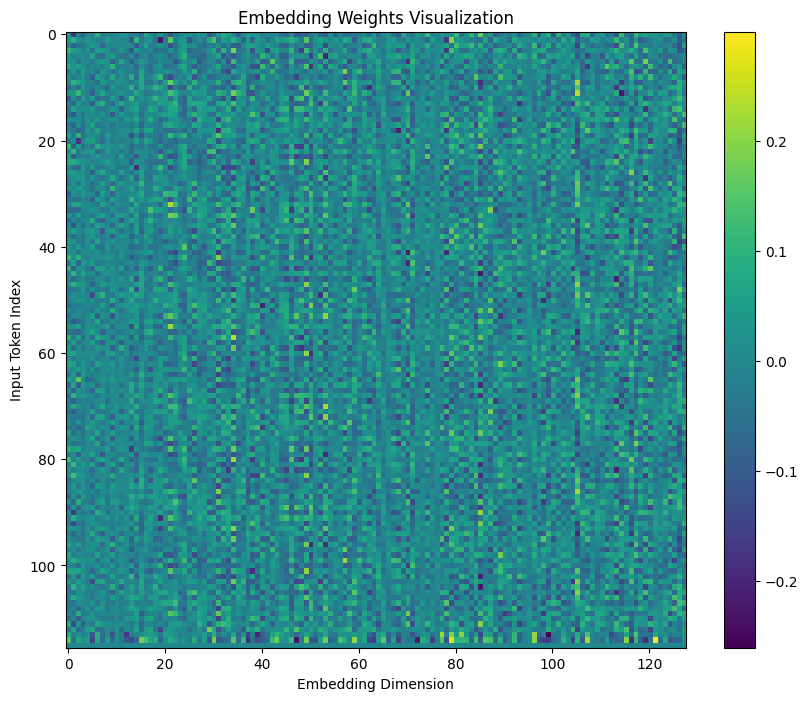

In [4]:
embeds = model.embedding.weight.detach().cpu().numpy()
# Visualize the embedding weights
plt.figure(figsize=(10, 8))
plt.imshow(embeds, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Embedding Weights Visualization')
plt.xlabel('Embedding Dimension')
plt.ylabel('Input Token Index')
plt.show()

In [5]:
example = torch.tensor([1, 113, 112, 114]).unsqueeze(0)  # Example input tensor
logits, activations = model(example, return_activations=True)

In [6]:
#argmax logits
predicted_token = torch.argmax(logits, dim=-1)
print(f"Predicted token for input {example.squeeze().tolist()}: {predicted_token.item()}")

Predicted token for input [1, 113, 112, 114]: 0


In [7]:
# generate combination of all inputs a and b range (113)
a = np.arange(113)
b = np.arange(113)
# generate inputs for the model
inputs = np.array([[a_i, 113, b_i, 114] for a_i in a for b_i in b])
inputs = torch.tensor(inputs)  # Add batch dimension
print(inputs.shape)
logits, activations = model(inputs, return_activations=True)

torch.Size([12769, 4])


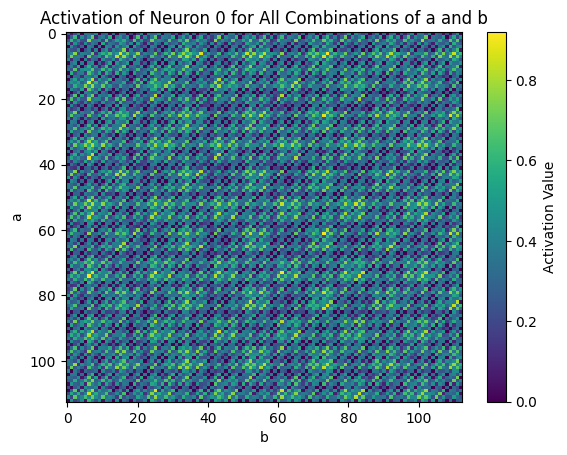

In [8]:
last_acts = activations[:, -1, :]
neuron_zero = activations[:, -1, 0] # shape (12769)
# keep dims 0 and 2 for inputs
input_ab = inputs[:, [0, 2]] # shape (12769, 2)
grid = neuron_zero.reshape(113, 113).detach().cpu().numpy()

plt.imshow(grid, aspect='auto', cmap='viridis')
plt.xlabel('b')
plt.ylabel('a')
plt.title('Activation of Neuron 0 for All Combinations of a and b')
plt.colorbar(label='Activation Value')
#every 20 ticks
plt.xticks(ticks=np.arange(0, 113, 20), labels=np.arange(0, 113, 20))
plt.yticks(ticks=np.arange(0, 113, 20), labels=np.arange(0, 113, 20))
plt.grid(False)
plt.show()

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
# or use: from matplotlib.animation import FuncAnimation, FFMpegWriter

# Get all neuron activations
all_neurons = activations[:, -1, :].detach().cpu().numpy()  # shape (12769, 512)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create the initial plot
grid = all_neurons[:, 0].reshape(113, 113)
im = ax.imshow(grid, aspect='auto', cmap='viridis', vmin=all_neurons.min(), vmax=all_neurons.max())

ax.set_xlabel('b')
ax.set_ylabel('a')
ax.set_title('Activation of Neuron 0 for All Combinations of a and b')
cbar = plt.colorbar(im, label='Activation Value')

# Set ticks
ax.set_xticks(np.arange(0, 113, 20))
ax.set_xticklabels(np.arange(0, 113, 20))
ax.set_yticks(np.arange(0, 113, 20))
ax.set_yticklabels(np.arange(0, 113, 20))
ax.grid(False)

def animate(frame):
    # Update the data
    grid = all_neurons[:, frame].reshape(113, 113)
    im.set_array(grid)
    ax.set_title(f'Activation of Neuron {frame} for All Combinations of a and b')
    return [im]

# Create animation
anim = FuncAnimation(fig, animate, frames=100, interval=100, blit=True, repeat=True)

# Save as GIF
anim.save('neuron_activations.gif', writer=PillowWriter(fps=10))

# Or save as MP4 (requires ffmpeg)
# anim.save('neuron_activations.mp4', writer=FFMpegWriter(fps=10))

plt.show()

KeyboardInterrupt: 

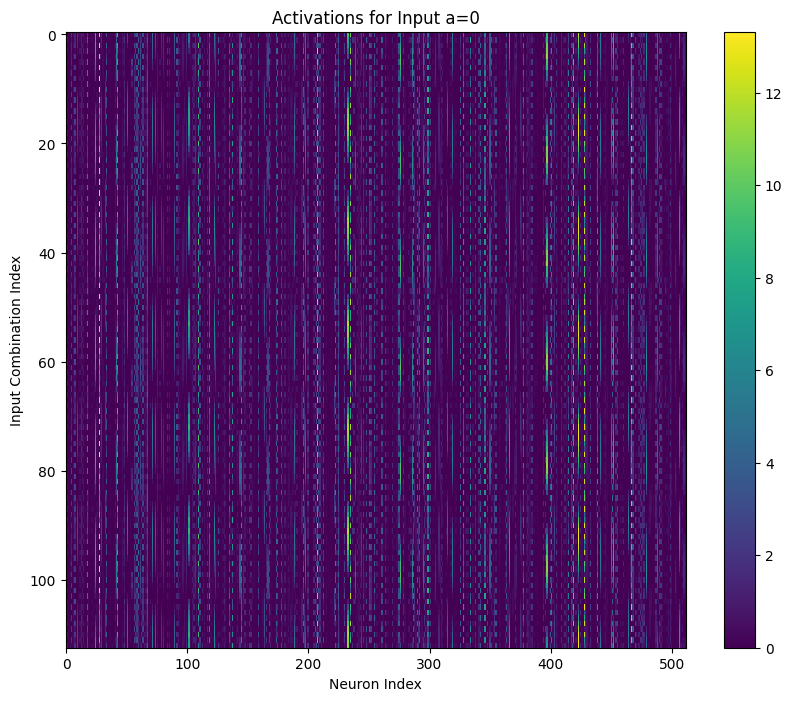

In [22]:
input_a = 0
#mask where a is input_a
mask = input_ab[:, 0] == input_a
# get the activations for this mask
activations_a = activations[mask][:, -1, :].detach().cpu().numpy()
b_values = input_ab[mask][:, 1]  # Get corresponding b values

# Visualize the activations for input_a
plt.figure(figsize=(10, 8))
plt.imshow(activations_a, aspect='auto', cmap='viridis', interpolation='None')
plt.colorbar()
plt.title(f'Activations for Input a={input_a}')
plt.xlabel('Neuron Index')
plt.ylabel('Input Combination Index')
plt.show()

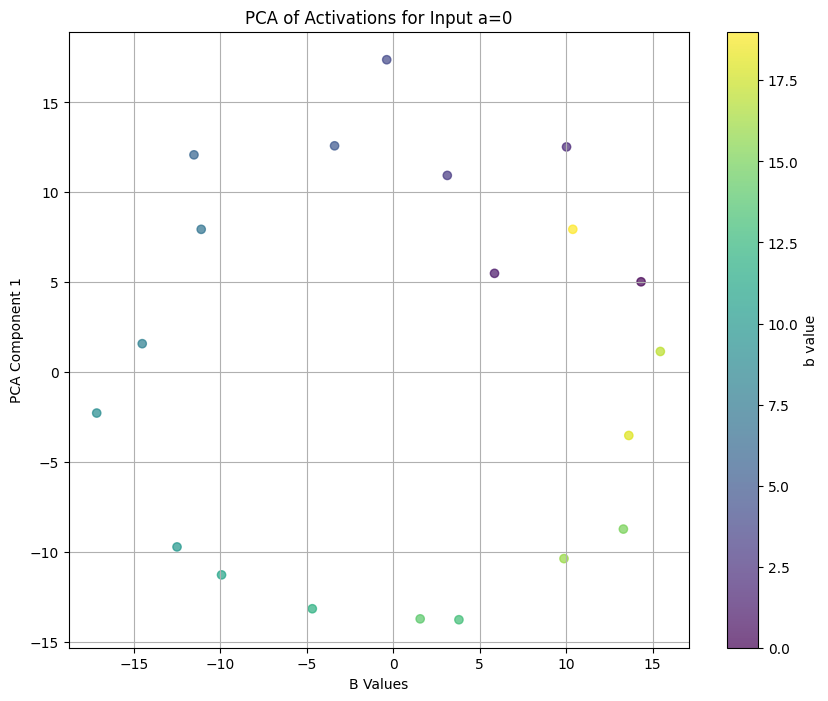

In [ ]:
from sklearn.decomposition import PCA
# Perform PCA on the activations for input_a
pca = PCA()
pca_result = pca.fit_transform(activations_a)
# Visualize PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[: ,0][:20], pca_result[:, 1][:20], alpha=0.7, c=b_values[:20], cmap='viridis')
plt.colorbar(label='b value')
plt.title(f'PCA of Activations for Input a={input_a}')
plt.xlabel('B Values')
plt.ylabel('PCA Component 1')
plt.grid()
plt.show()

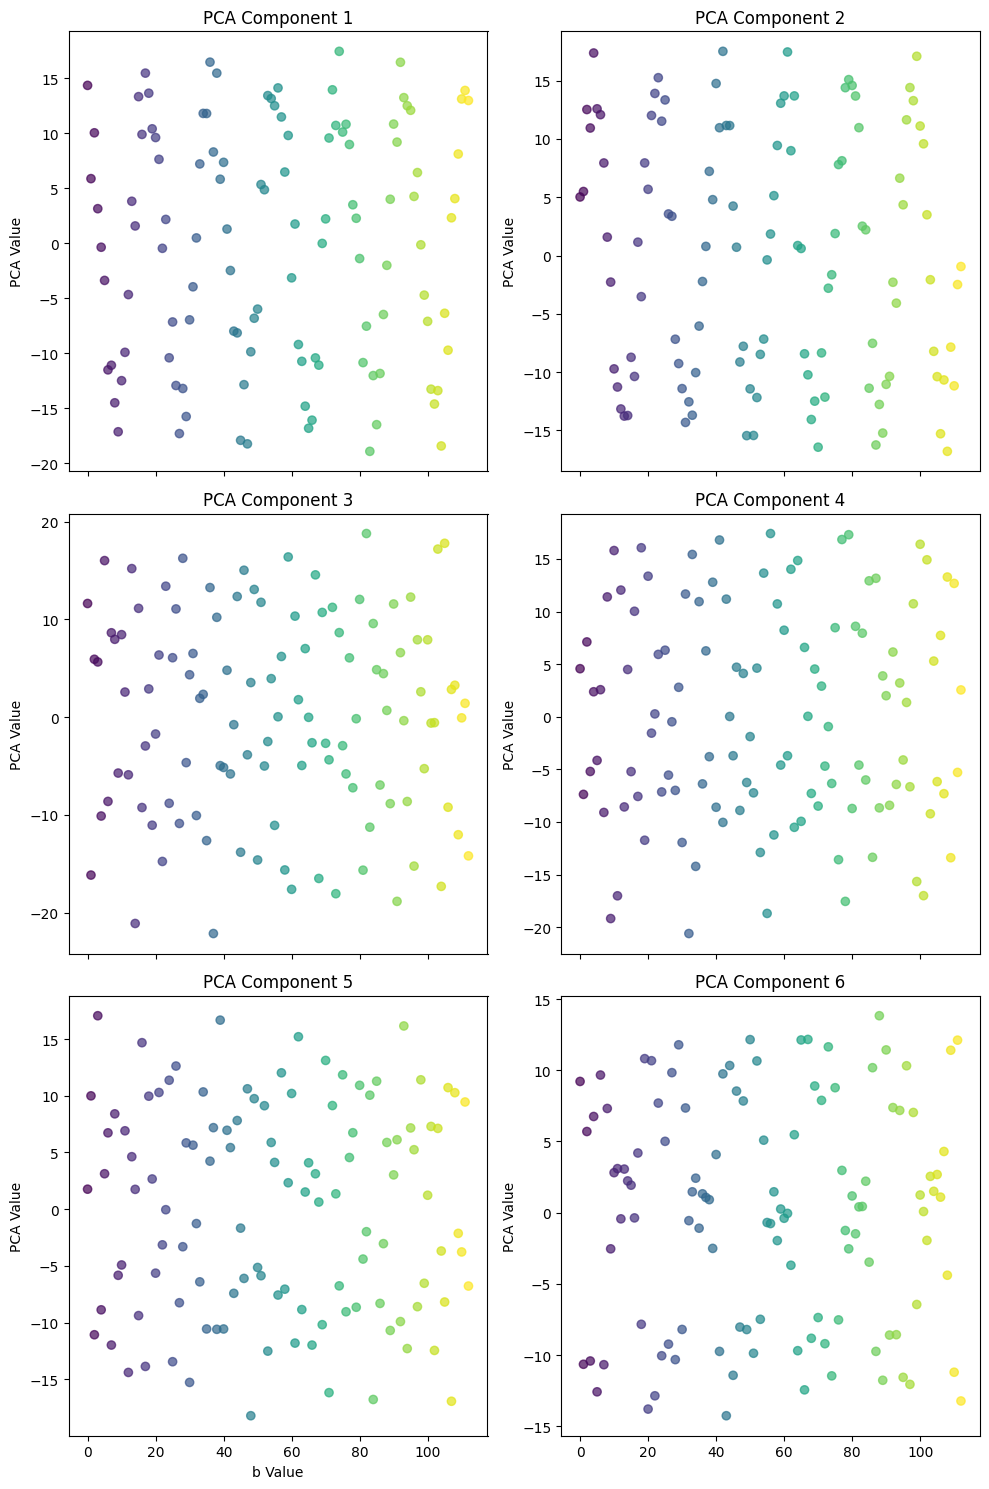

In [36]:
from sklearn.decomposition import PCA
# Perform PCA on the activations for input_a
pca = PCA()
pca_result = pca.fit_transform(activations_a)
# plot b values against the first 5 pca components and explain variance in subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharex=True)
for i in range(6):
    axes[i // 2, i % 2].scatter(b_values, pca_result[: , i], alpha=0.7, c=b_values, cmap='viridis')
    axes[i // 2, i % 2].set_title(f'PCA Component {i+1}')
    axes[i // 2, i % 2].set_ylabel('PCA Value')
axes[-1, 0].set_xlabel('b Value')
plt.tight_layout()
plt.show()

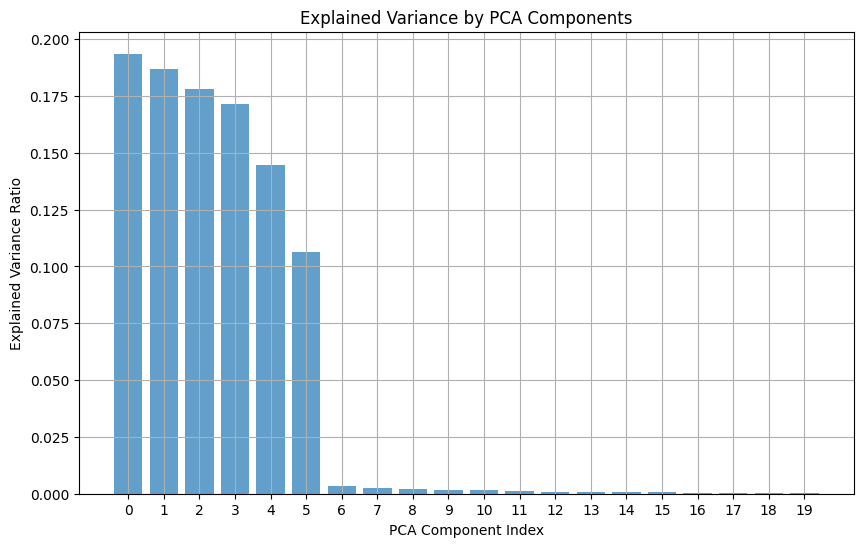

In [37]:
#bar plot of explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(len(pca.explained_variance_ratio_[:20])), pca.explained_variance_ratio_[:20], alpha=0.7)
plt.title('Explained Variance by PCA Components')
plt.xlabel('PCA Component Index')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(len(pca.explained_variance_ratio_[:20])))
plt.grid()
plt.show()